# Fake news detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,WATCH: This Video Of The GOP’S Convention Hor...,The recently concluded Republican National Con...,News,"July 23, 2016",fake
1,BREAKING: VIDEO OF YOUNG OBAMA EMERGES Discuss...,Who needs family when you have a neighborhood ...,politics,"Apr 14, 2015",fake
2,Mexican ruling party to pick presidential cand...,MEXICO CITY (Reuters) - Mexico s ruling Instit...,worldnews,"November 24, 2017",true
3,Senator says Russian internet trolls stoked NF...,WASHINGTON (Reuters) - A U.S. senator on Wedne...,worldnews,"September 27, 2017",true
4,"Turkey's Erdogan, U.S. Trump discuss Syria, bi...",ANKARA (Reuters) - Turkish President Tayyip Er...,worldnews,"November 24, 2017",true


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,WATCH: This Video Of The GOP’S Convention Hor...,The recently concluded Republican National Con...,News,fake
1,BREAKING: VIDEO OF YOUNG OBAMA EMERGES Discuss...,Who needs family when you have a neighborhood ...,politics,fake
2,Mexican ruling party to pick presidential cand...,MEXICO CITY (Reuters) - Mexico s ruling Instit...,worldnews,true
3,Senator says Russian internet trolls stoked NF...,WASHINGTON (Reuters) - A U.S. senator on Wedne...,worldnews,true
4,"Turkey's Erdogan, U.S. Trump discuss Syria, bi...",ANKARA (Reuters) - Turkish President Tayyip Er...,worldnews,true


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,The recently concluded Republican National Con...,News,fake
1,Who needs family when you have a neighborhood ...,politics,fake
2,MEXICO CITY (Reuters) - Mexico s ruling Instit...,worldnews,true
3,WASHINGTON (Reuters) - A U.S. senator on Wedne...,worldnews,true
4,ANKARA (Reuters) - Turkish President Tayyip Er...,worldnews,true


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,the recently concluded republican national con...,News,fake
1,who needs family when you have a neighborhood ...,politics,fake
2,mexico city (reuters) - mexico s ruling instit...,worldnews,true
3,washington (reuters) - a u.s. senator on wedne...,worldnews,true
4,ankara (reuters) - turkish president tayyip er...,worldnews,true


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,the recently concluded republican national con...,News,fake
1,who needs family when you have a neighborhood ...,politics,fake
2,mexico city reuters mexico s ruling instituti...,worldnews,true
3,washington reuters a us senator on wednesday ...,worldnews,true
4,ankara reuters turkish president tayyip erdog...,worldnews,true


In [14]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\Administrator.DE
[nltk_data]     SKTOP-R4FAM4Q\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data.head()

,text,subject,target
0,recently concluded republican national convent...,News,fake
1,needs family neighborhood mentor teach value r...,politics,fake
2,mexico city reuters mexico ruling institutiona...,worldnews,true
3,washington reuters us senator wednesday said r...,worldnews,true
4,ankara reuters turkish president tayyip erdoga...,worldnews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


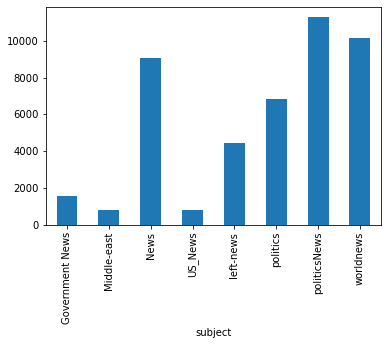

In [16]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


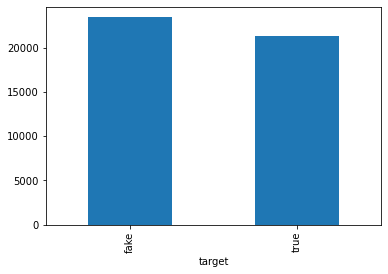

In [17]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

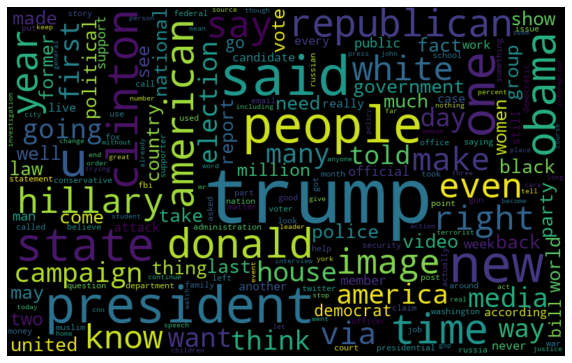

In [18]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

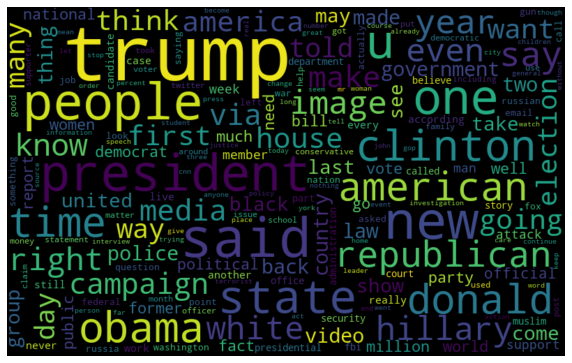

In [19]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# Most frequent words counter   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

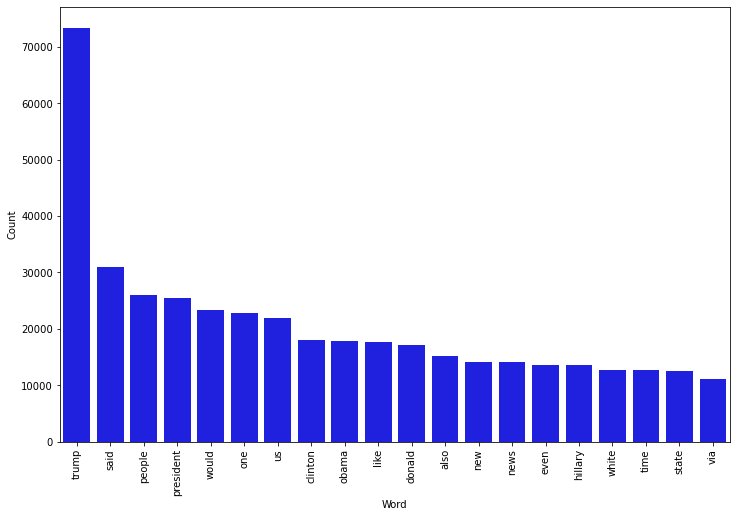

In [21]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

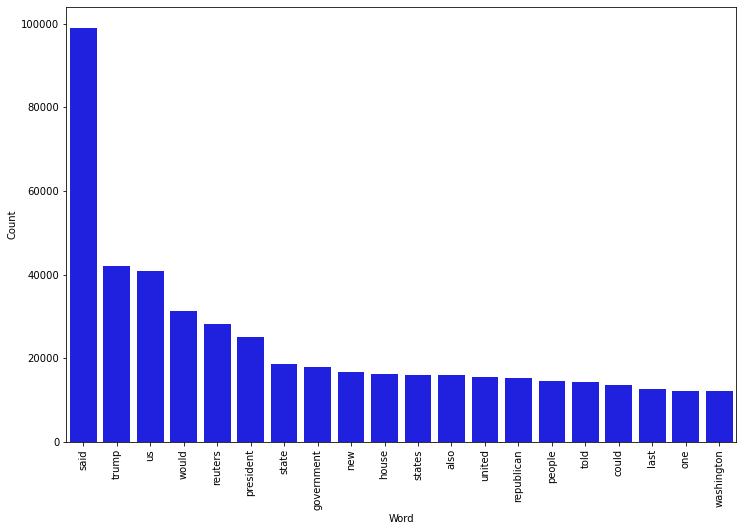

In [22]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

### Peparing the data

In [24]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

In [25]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.9%


Confusion matrix, without normalization


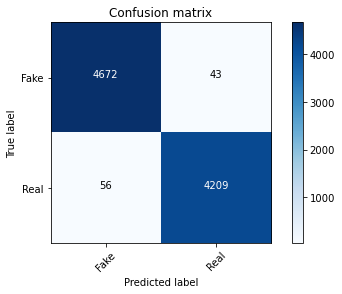

In [26]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [27]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.61%


Confusion matrix, without normalization


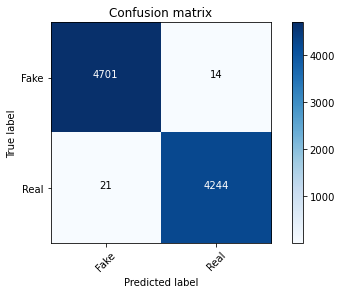

In [28]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.11%


Confusion matrix, without normalization


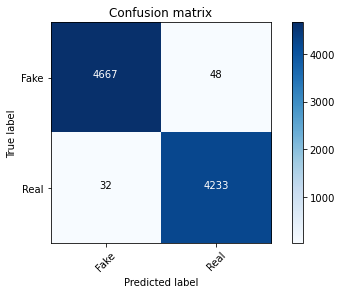

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])